In [9]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import torch
from epam.dnsm import TransformerBinarySelectionModel, DNSMBurrito
from epam.sequences import translate_sequences, translate_sequence
from epam.shmple_precompute import load_and_convert_to_tensors

In [2]:
pcp_df = load_and_convert_to_tensors("/Users/matsen/data/wyatt-10x-1p5m_pcp_2023-10-07.shmple.hdf5")

# filter out rows of pcp_df where the parent and child sequences are identical
pcp_df = pcp_df[pcp_df["parent"] != pcp_df["child"]]

pcp_df["v_family"] = pcp_df["v_gene"].str.split("-").str[0]

pcp_df["v_family"].value_counts()

v_family
IGHV3    36198
IGHV4    13131
IGHV1     5858
IGHV5     2130
IGHV2     1581
IGHV6      855
IGHV7      540
Name: count, dtype: int64

In [3]:
chosen_v_families = set(["IGHV3", "IGHV4"])
per_v_family_count = 10000  # or however many you need
                        
# only keep rows where v_family is in chosen_v_families
pcp_df = pcp_df[pcp_df["v_family"].isin(chosen_v_families)]

# Group by 'v_family' and sample per_v_family_count from each group
sampled_groups = [
    group.sample(n=per_v_family_count)
    for name, group in pcp_df.groupby('v_family')
]

# Concatenate all the sampled groups back into one DataFrame
pcp_df = pd.concat(sampled_groups)

# Reset index if you want a clean index
pcp_df.reset_index(drop=True, inplace=True)


print(f"We have {len(pcp_df)} PCPs.")


We have 20000 PCPs.


In [4]:
nhead = 4
dim_feedforward = 2048
layer_count = 3

dnsm = TransformerBinarySelectionModel(
    nhead=nhead, dim_feedforward=dim_feedforward, layer_count=layer_count
)

burrito = DNSMBurrito(pcp_df, dnsm, batch_size=1024, learning_rate=0.001, checkpoint_dir="./_checkpoints", log_dir="./_logs")

Using Metal Performance Shaders
preparing data...
consolidating shmple rates into substitution probabilities...
consolidating shmple rates into substitution probabilities...


In [5]:
burrito.train(3)
burrito.optimize_branch_lengths()
burrito.train(50)
burrito.optimize_branch_lengths()
burrito.train(50)
# burrito.writer.close()

Epoch [0/3], Training Loss: 0.14294319972395897, Validation Loss: 0.14063894748687744
training model...
Epoch [1/3], Training Loss: 0.13826358318328857, Validation Loss: 0.13851002603769302
Epoch [2/3], Training Loss: 0.13508546352386475, Validation Loss: 0.13826090842485428
Epoch [3/3], Training Loss: 0.13203178346157074, Validation Loss: 0.13732388988137245


Finding optimal branch lengths: 100%|██████████| 16000/16000 [07:01<00:00, 37.95it/s]


consolidating shmple rates into substitution probabilities...


Finding optimal branch lengths: 100%|██████████| 4000/4000 [01:44<00:00, 38.40it/s]


consolidating shmple rates into substitution probabilities...
Epoch [0/50], Training Loss: 0.13750505447387695, Validation Loss: 0.13544369861483574
training model...
Epoch [1/50], Training Loss: 0.13854621350765228, Validation Loss: 0.13504181429743767
Epoch [2/50], Training Loss: 0.1323000192642212, Validation Loss: 0.13483692705631256
Epoch [3/50], Training Loss: 0.1339704543352127, Validation Loss: 0.13468727841973305
Epoch [4/50], Training Loss: 0.13741697371006012, Validation Loss: 0.13445540517568588
Epoch [5/50], Training Loss: 0.13442741334438324, Validation Loss: 0.1343304142355919
Epoch [6/50], Training Loss: 0.1402394026517868, Validation Loss: 0.13431749492883682
Epoch [7/50], Training Loss: 0.1372576355934143, Validation Loss: 0.13384554535150528
Epoch [8/50], Training Loss: 0.14024987816810608, Validation Loss: 0.133713997900486
Epoch [9/50], Training Loss: 0.13424120843410492, Validation Loss: 0.13366036117076874
Epoch [10/50], Training Loss: 0.1428157240152359, Validat

Finding optimal branch lengths: 100%|██████████| 16000/16000 [04:36<00:00, 57.93it/s]


consolidating shmple rates into substitution probabilities...


Finding optimal branch lengths: 100%|██████████| 4000/4000 [01:05<00:00, 60.94it/s]


consolidating shmple rates into substitution probabilities...
Epoch [0/50], Training Loss: 0.1358958212658763, Validation Loss: 0.13329263776540756
training model...
Epoch [1/50], Training Loss: 0.13347820937633514, Validation Loss: 0.1327665075659752
Epoch [2/50], Training Loss: 0.13498914241790771, Validation Loss: 0.1329897902905941
Epoch [3/50], Training Loss: 0.13054916262626648, Validation Loss: 0.1328658051788807
Epoch [4/50], Training Loss: 0.14072421193122864, Validation Loss: 0.13285578042268753
Epoch [5/50], Training Loss: 0.13223622739315033, Validation Loss: 0.13284927234053612
Epoch [6/50], Training Loss: 0.13750553131103516, Validation Loss: 0.13254646956920624
Epoch [7/50], Training Loss: 0.13783331215381622, Validation Loss: 0.13280948996543884
Epoch [8/50], Training Loss: 0.1379498839378357, Validation Loss: 0.13259421288967133
Epoch [9/50], Training Loss: 0.13407950103282928, Validation Loss: 0.13279742002487183
Epoch [10/50], Training Loss: 0.14078453183174133, Vali

In [6]:
[aa_str] = translate_sequences([pcp_df.reset_index(drop=True).loc[0, "parent"]])
burrito.dnsm.selection_factors_of_aa_str(aa_str)

tensor([0.4268, 0.5874, 0.5765, 0.5824, 0.4928, 0.4712, 0.1860, 0.2759, 0.4842,
        0.5859, 0.5248, 0.3739, 0.3736, 0.2723, 0.4654, 0.5039, 0.3876, 0.4663,
        0.9958, 0.4212, 0.3923, 0.1278, 1.0000, 1.0000, 0.6713, 0.5286, 0.4495,
        1.0000, 0.5209, 0.8760, 0.5068, 0.4558, 0.1184, 0.6591, 0.7177, 0.1232,
        0.3958, 0.2578, 0.2987, 0.7289, 0.5786, 0.7387, 0.7853, 0.8238, 0.6664,
        0.5104, 0.2843, 0.5786, 0.6090, 0.6458, 0.9166, 1.0000, 0.9979, 0.9080,
        0.9442, 1.0000, 0.9399, 1.0000, 0.9980, 0.9883, 1.0000, 1.0000, 0.9746,
        1.0000, 1.0000, 1.0000, 0.5295, 0.9002, 1.0000, 1.0000, 1.0000, 0.4995,
        0.2635, 0.9230, 1.0000, 0.8802, 0.9442, 0.9613, 0.8933, 1.0000, 0.6489,
        1.0000, 0.6315, 1.0000, 1.0000, 0.8057, 1.0000, 1.0000, 0.5278, 0.4088,
        1.0000, 1.0000, 1.0000, 0.4612, 0.4702, 0.1172, 1.0000, 1.0000, 0.8515,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.9682, 0.8930, 0.9594,
        0.1843, 0.8671, 0.9600, 0.8509, 

In [7]:
# nhead = 4
# dim_feedforward = 2048
# layer_count = 3
# 
# model = TransformerBinarySelectionModel(
#     nhead=nhead, dim_feedforward=dim_feedforward, layer_count=layer_count
# )
# 
# model.load_state_dict(torch.load("/Users/matsen/re/epam/trained_dnsms/dnsm-2023-11-01-09-32.pth")["model_state_dict"])
# model.eval()
# model.selection_factors_of_aa_str(aa_str)

In [10]:
pcp_df["parent_len"] = pcp_df["parent"].str.len()
pcp_df.head()

# find the single most common parent length overall
most_common_parent_len = pcp_df["parent_len"].value_counts().idxmax()

for group in pcp_df.groupby("v_family"):
    # print how many rows there are with parent_length == most_common_parent_len
    print(group[0], len(group[1][group[1]["parent_len"] == most_common_parent_len]))

same_parent_len_df = pcp_df[pcp_df["parent_len"] == most_common_parent_len]

IGHV3 1041
IGHV4 1256


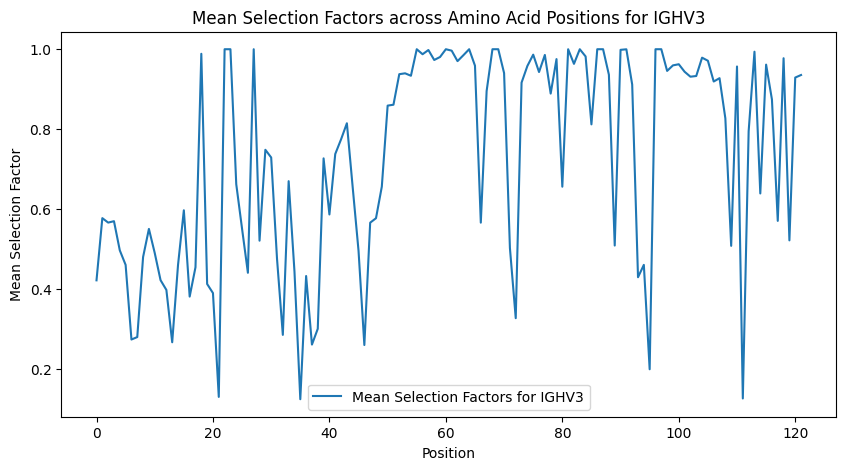

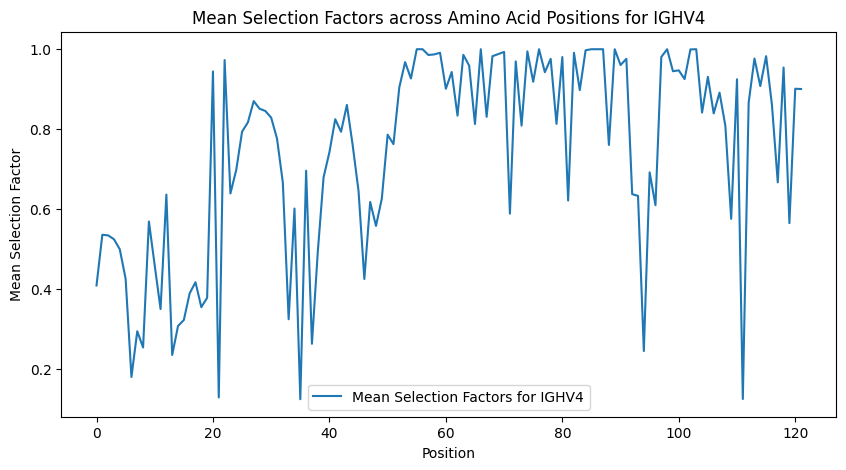

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming pcp_df is your DataFrame, plot_sample_count is defined, and the other functions are imported
plot_sample_count = 10  # or set to your specific requirement

# Keep only the 'v_family' and 'parent' columns for processing
df = same_parent_len_df[['v_family', 'parent']]

# Step 1: Sample the DataFrame according to your requirements
sampled_dfs = []
for v_family, group in df.groupby('v_family'):
    if len(group) > plot_sample_count:
        sampled_group = group.sample(n=plot_sample_count)
    else:
        sampled_group = group
    sampled_dfs.append(sampled_group)

# Concatenate the sampled DataFrames
sampled_df = pd.concat(sampled_dfs)

# Step 2: Translate the "parent" sequences to amino acid strings
sampled_df['aa_str'] = sampled_df['parent'].apply(translate_sequence)

# Step 3: Compute the mean selection factors for amino acid strings
def compute_mean_selection_factors(row):
    return burrito.dnsm.selection_factors_of_aa_str(row['aa_str']).cpu().numpy()

sampled_df['selection_factors'] = sampled_df.apply(compute_mean_selection_factors, axis=1)

# Step 4: Plot the mean selection factors for each v_family
for v_family, group in sampled_df.groupby('v_family'):
    # Assuming 'mean_selection_factors' is a list of means per position
    mean_selection_factors = group['selection_factors'].mean(axis=0)
    
    plt.figure(figsize=(10, 5))
    plt.plot(mean_selection_factors, label=f'Mean Selection Factors for {v_family}')
    plt.xlabel('Position')
    plt.ylabel('Mean Selection Factor')
    plt.title(f'Mean Selection Factors across Amino Acid Positions for {v_family}')
    plt.legend()
    plt.show()


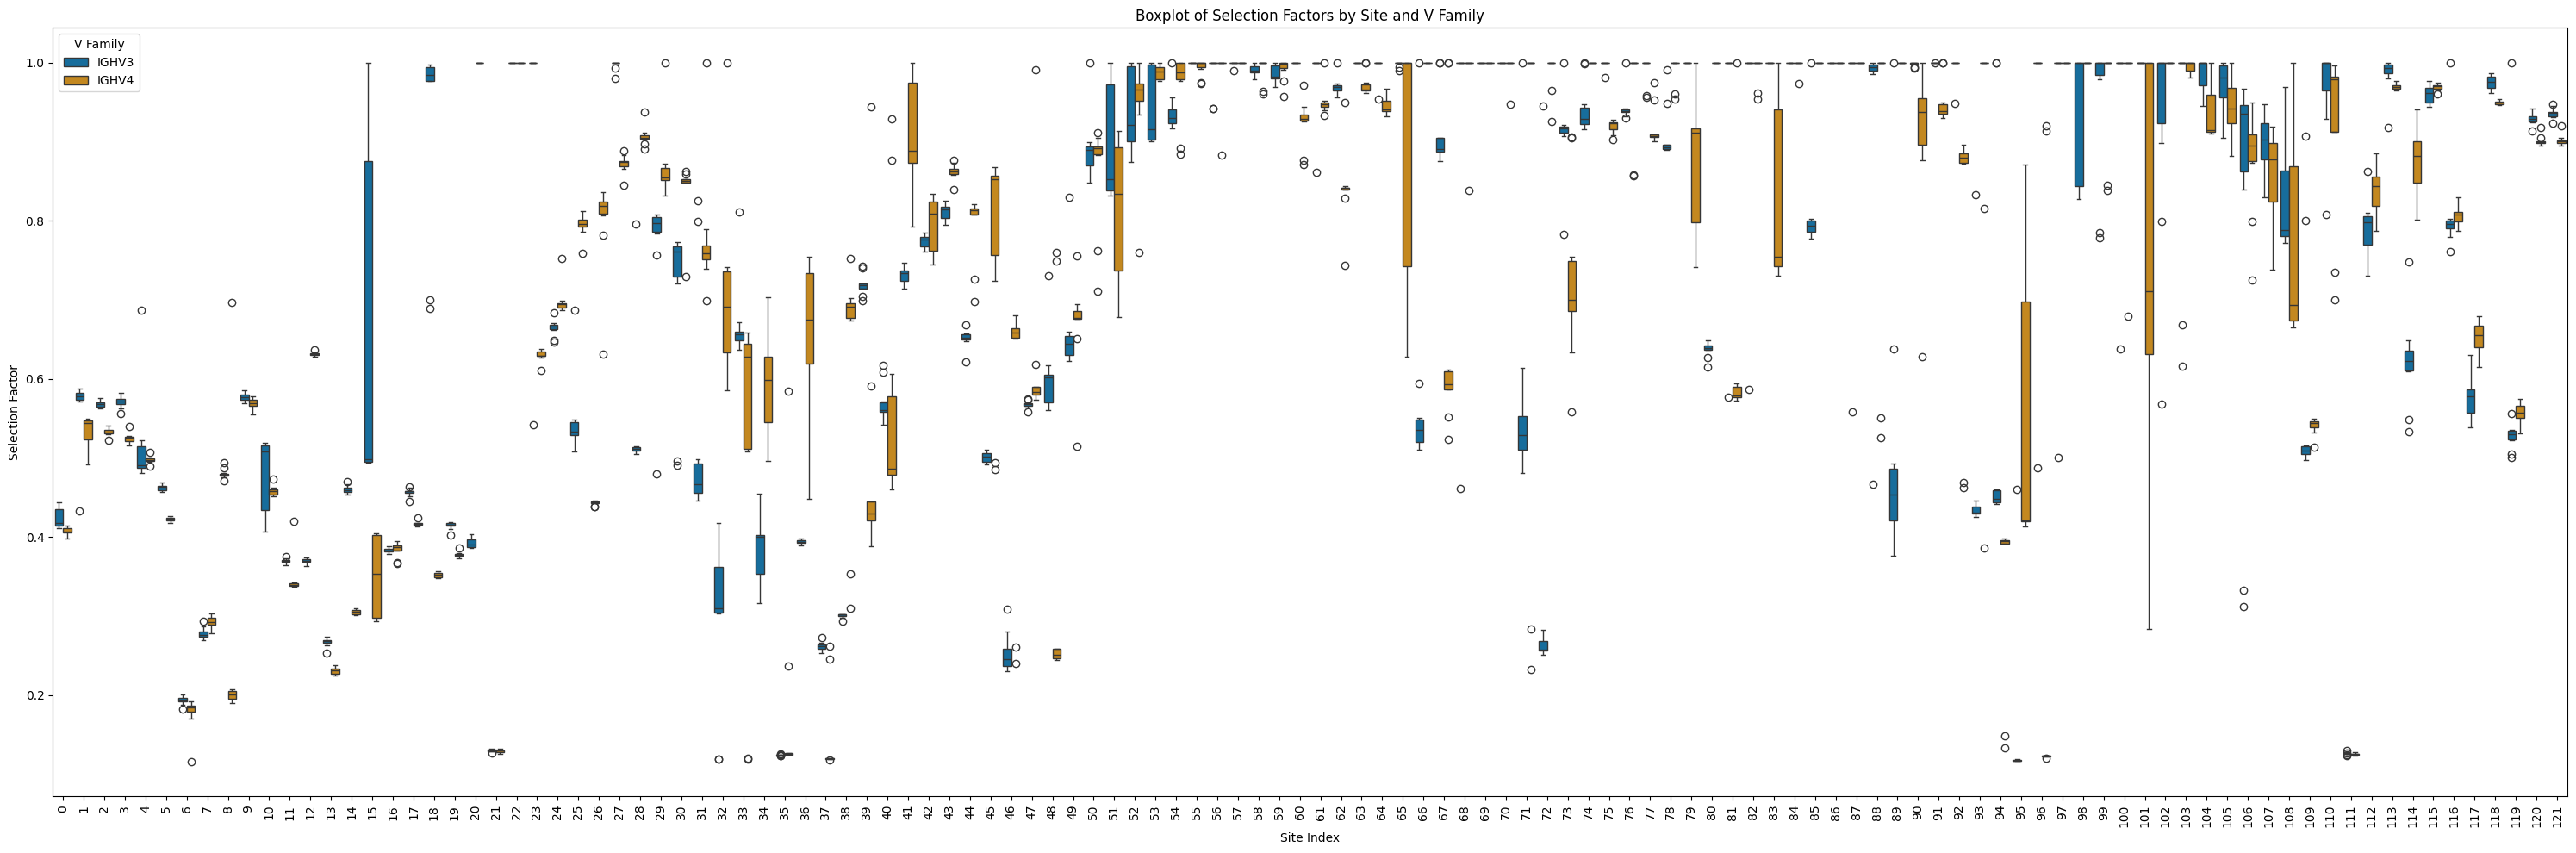

In [16]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming same_parent_len_df is your DataFrame and plot_sample_count is defined
plot_sample_count = 100  # or set to your specific requirement

# Keep only the 'v_family' and 'parent' columns for processing
df = same_parent_len_df[['v_family', 'parent']]

# Step 1: Sample the DataFrame according to your requirements
sampled_dfs = []
for v_family, group in df.groupby('v_family'):
    if len(group) > plot_sample_count:
        sampled_group = group.sample(n=plot_sample_count)
    else:
        sampled_group = group
    sampled_dfs.append(sampled_group)

# Concatenate the sampled DataFrames
sampled_df = pd.concat(sampled_dfs)

# Step 2: Translate the "parent" sequences to amino acid strings
sampled_df['aa_str'] = sampled_df['parent'].apply(translate_sequence)

# Step 3: Compute selection factors for each amino acid string
sampled_df['selection_factors'] = sampled_df['aa_str'].apply(burrito.dnsm.selection_factors_of_aa_str)

# Flatten the selection factors into a list with corresponding v_family labels and site index for plotting
plot_data = []
for index, row in sampled_df.iterrows():
    selection_factors_array = row['selection_factors'].cpu().numpy()
    for site_index, selection_factor in enumerate(selection_factors_array):
        plot_data.append({'v_family': row['v_family'], 'site_index': site_index, 'selection_factor': selection_factor})

plot_df = pd.DataFrame(plot_data)

# Step 4: Create the boxplot colored by v_family
plt.figure(figsize=(30, 10))  # Adjust the figure size as needed
sns.boxplot(x='site_index', y='selection_factor', hue='v_family', data=plot_df, palette='colorblind')
plt.xticks(rotation=90)  # Rotate the x-ticks if there are many sites
plt.xlabel('Site Index')
plt.ylabel('Selection Factor')
plt.title('Boxplot of Selection Factors by Site and V Family')
plt.legend(title='V Family')
plt.tight_layout()  # This will make sure everything fits without overlapping (might be necessary with many sites)
plt.show()
